*   Network     : Inception v2
*   Optimizer   : SGD
*   Regularizer : No regularization

Ref for code: https://arxiv.org/pdf/1512.00567v3.pdf

In [1]:
from __future__ import print_function

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras import callbacks

from keras.applications.imagenet_utils import preprocess_input
from keras.datasets import cifar100
from keras.initializers import glorot_uniform
from keras.layers.core import Lambda
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, concatenate
from keras.models import Model, load_model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils, data_utils, vis_utils, plot_model #data_utils.get_file #vis_utils.model_to_dot

import numpy as np
import pydot
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [2]:
#Loading cifar100 dataset and dividing into Train, Validation and Test sets

(X_train, Y_train), (x_test, y_test_o) = cifar100.load_data()

X_train = X_train.astype('float32')
x_test = x_test.astype('float32')

x_train, x_validation, y_train, y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

y_train = keras.utils.to_categorical(y_train, 100)
y_validation = keras.utils.to_categorical(y_validation, 100)
y_test = keras.utils.to_categorical(y_test_o, 100)

In [3]:
weight_decay = 0.0005
num_of_classes = 100
conv_activation_func = 'elu'

l_rate = 0.1
batch_size = 128
maxepoches = 40
lr_decay = 1e-6

In [4]:
def inceptionv2(input):
    model = Sequential()

    ##### MAIN LAYER #####
    main = Conv2D(64, (3, 3), strides=(2,2), padding='same',activation=conv_activation_func)(input)
    main = Conv2D(64, (3, 3), strides = (1,1), padding='same', activation=conv_activation_func)(main)
    main = Conv2D(64, (3, 3), strides = (1,1), padding='same', activation=conv_activation_func)(main)

    main = MaxPooling2D(pool_size=(2, 2))(main)

    main = Conv2D(64, (3, 3), strides = (1,1), padding='same', activation=conv_activation_func)(main)
    main = Conv2D(64, (3, 3), strides = (2,2), padding='same', activation=conv_activation_func)(main)
    main = Conv2D(64, (3, 3), strides = (1,1), padding='same', activation=conv_activation_func)(main)

    ######Inception module A#####
    main = inception_A(main)
    main = inception_A(main)
    main = inception_A(main)

    ######Inception module B#####
    main = inception_B(main)
    main = inception_B(main)
    main = inception_B(main)
    main = inception_B(main)
    main = inception_B(main)

    ######Inception module C#####
    main = inception_C(main)
    main = inception_C(main)

    main = AveragePooling2D(pool_size=(3, 3))(main)

    main = Flatten()(main)
    dense = Dense(10, activation='linear')(main)
    
    output = Dense(num_of_classes, activation='softmax')(dense)
    return output

In [5]:
def inception_A(input):
  pll1 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)
  pll1 = Conv2D(64, (3,3), padding='same', activation=conv_activation_func)(pll1)
  pll1 = Conv2D(64, (3,3), padding='same', activation=conv_activation_func)(pll1)

  pll2 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)
  pll2 = Conv2D(64, (3,3), padding='same', activation=conv_activation_func)(pll2)
  
  pll3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input)

  pll3 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(pll3)
  
  pll4 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)

  output = keras.layers.concatenate([pll1, pll2, pll3, pll4], axis=3)

  return output

In [6]:
def inception_B(input):
  pll1 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)
  pll1 = Conv2D(64, (1,3), padding='same', activation=conv_activation_func)(pll1)
  pll1 = Conv2D(64, (3,1), padding='same', activation=conv_activation_func)(pll1)
  pll1 = Conv2D(64, (1,3), padding='same', activation=conv_activation_func)(pll1)
  pll1 = Conv2D(64, (3,1), padding='same', activation=conv_activation_func)(pll1)

  pll2 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input) 
  pll2 = Conv2D(64, (1,3), padding='same', activation=conv_activation_func)(pll2)
  pll2 = Conv2D(64, (3,1), padding='same', activation=conv_activation_func)(pll2)

  pll3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
  
  pll3 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(pll3)

  pll4 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)

  output = keras.layers.concatenate([pll1, pll2, pll3, pll4], axis = 3)

  return output

In [7]:
def inception_C(input):
  pll1 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)
  pll1 = Conv2D(64, (3,3), padding='same', activation=conv_activation_func)(pll1)

  pll1_a = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(pll1)
  pll1_b = Conv2D(64, (3,3), padding='same', activation=conv_activation_func)(pll1)

  pll2 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)
  
  pll2_a = Conv2D(64, (1,3), padding='same', activation=conv_activation_func)(pll2)
  pll2_b = Conv2D(64, (3,1), padding='same', activation=conv_activation_func)(pll2)

  pll3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input)
  pll3 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(pll3)

  pll4 = Conv2D(64, (1,1), padding='same', activation=conv_activation_func)(input)

  output = concatenate([pll1_a, pll1_b, pll2_a, pll2_b, pll3, pll4], axis=3)
  return output

In [8]:
#Definition of SGD optimizer
sgd = optimizers.SGD(learning_rate=l_rate)#, decay=lr_decay,momentum=0.9, nesterov=True)

input = Input(shape=(32, 32, 3))
output = inceptionv2(input)

model = Model([input], output)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [9]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [10]:
#Defintion of callbacks with EarlyStopping 
callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Definition of saving the best weights of the model with ModelCheckpoint
checkpoint_path = "checkpoints"
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='min')

#Training the model in the training dataset
history = model.fit(x_train, y_train, epochs = maxepoches, batch_size = batch_size, validation_data=(x_validation, y_validation), callbacks=[callback, checkpoint])
model.save_weights('InceptionV2_SGD_NoRegularization.h5')

Epoch 1/40
313/313 [==============================] - ETA: 0s - loss: 4.4875 - accuracy: 0.0260
Epoch 00001: val_loss improved from inf to 4.29057, saving model to checkpoints
313/313 [==============================] - 11s 34ms/step - loss: 4.4875 - accuracy: 0.0260 - val_loss: 4.2906 - val_accuracy: 0.0349
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 4.2103 - accuracy: 0.0475
Epoch 00002: val_loss improved from 4.29057 to 4.22153, saving model to checkpoints
313/313 [==============================] - 10s 31ms/step - loss: 4.2103 - accuracy: 0.0475 - val_loss: 4.2215 - val_accuracy: 0.0506
Epoch 3/40
311/313 [============================>.] - ETA: 0s - loss: 4.0186 - accuracy: 0.0724
Epoch 00003: val_loss improved from 4.22153 to 4.06076, saving model to checkpoints
313/313 [==============================] - 10s 31ms/step - loss: 4.0191 - accuracy: 0.0724 - val_loss: 4.0608 - val_accuracy: 0.0697
Epoch 4/40
313/313 [==============================] - ETA: 0s - l

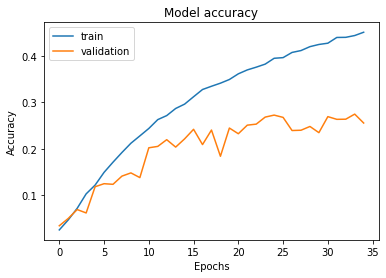

In [11]:
#Plot the Training and Validation accuracy v/s Epochs
#history.keys() = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

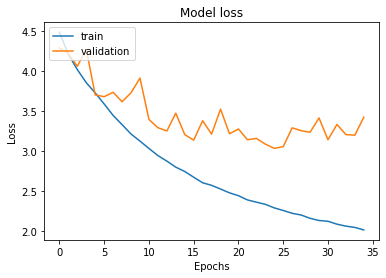

In [12]:
#Plot the Training and Validation loss v/s Epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
#Testing the model using the best weights of the model

model.load_weights('./InceptionV2_SGD_NoRegularization.h5')
loss, acc = model.evaluate(x_test,  y_test, verbose=2)

predict_y_test_o = model.predict(x_test, verbose=0)

313/313 - 2s - loss: 3.4093 - accuracy: 0.2559


In [14]:
# #Precision, recall and accuracy of the model on test data
predict_y_test = np.argmax(predict_y_test_o, axis=1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_o, predict_y_test)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test_o, predict_y_test, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test_o, predict_y_test, average='macro')
print('Recall: %f' % recall)

# Confusion matrix
confusion_matrix_ = confusion_matrix(y_test_o, predict_y_test)
print(confusion_matrix_)

Accuracy: 0.255900
Precision: 0.282296
Recall: 0.255900
[[62  0  0 ...  0  0  0]
 [ 7 25  1 ...  1  0  0]
 [ 1  1 20 ...  2  2  1]
 ...
 [ 0  0  1 ... 16  0  1]
 [ 1  1  8 ...  3  3  1]
 [ 0  0  0 ...  0  0 19]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


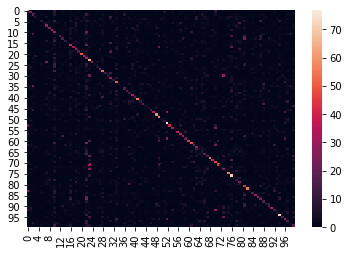

In [15]:
import seaborn as sb
heat_map = sb.heatmap(confusion_matrix_)
plt.show()